# Predicting Solar Flares with Flux Emergence Data

In this notebook, we will download and extract features from flux emergence data taken from Helioseismic and Magnetic Imager (HMI) instrument on NASA's Solar Dynamics Observatory (SDO) satellite, and train a machine learning model to predict the likelihood of an active region flaring.

The metadata from the HMI instrument is stored in a database called the Data Record Management System, or DRMS. This data can be accessed using the `drms` module. We will begin by importing the data.

In [1]:
import drms
import csv
import numpy as np
import sunpy
import sunpy.instr.goes
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdate

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from pandas.plotting import register_matplotlib_converters
from datetime import datetime

## Downloading Data

JSOC (Joint Science Operations Center) keeps an up-to-date catalog of all the active regions observed on the sun. This can be found here: `http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt`. The code block below takes a file `./all_harps_with_noaa_ars.txt` (which is a downloaded version of the aforementioned link) and extracts the harp_ids, as well as a dictionary of harp_ids corresponding to noaa_ids.

To download the newest version of the file, one could use a tool such as `wget`: `wget http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt`

In [2]:
def get_harp_ids_and_harp_noaa_dict():
    harp_ids = []
    harp_noaa_dict = {}
    with open("all_harps_with_noaa_ars.txt") as f:
        content = f.readlines()[1:] # Disregard the header line
        for line in content:
            harp_id = line.split()[0]
            noaa_ids = line.split()[1].split(',')
            harp_ids.append(harp_id)
            harp_noaa_dict[harp_id] = noaa_ids
    print(len(harp_ids), 'HARP IDs found')
    return harp_ids, harp_noaa_dict
harp_ids, harp_noaa_dict = get_harp_ids_and_harp_noaa_dict()

1335 HARP IDs found


In [3]:
def query_data(harp_id, client):
    query_string = 'hmi.sharp_cea_720s[' + str(harp_id) + ']'
    return client.query(query_string, key='T_REC, USFLUX')

In [4]:
def parse_time_string(t_str):
    year   = int(t_str[:4])
    month  = int(t_str[5:7])
    day    = int(t_str[8:10])
    hour   = int(t_str[11:13])
    minute = int(t_str[14:16])
    return datetime(year, month, day, hour, minute)

In [5]:
def get_time_data(keys):
    start_time = parse_time_string(keys.T_REC[0])
    time_data = []
    for i in range(keys.T_REC.size):
        time = parse_time_string(keys.T_REC[i])
        time_delta = (time - start_time).total_seconds() / (60 * 60) # Convert to hours
        time_data.append(time_delta)
    return time_data

## Data Visualization

We want to be able to graph the data in order to visually understand the differences between the flux vs. time graphs of flaring and non-flaring active regions.

In [6]:
def plot_graph(keys, time_data):
    """This method takes the keys data querried from the DRMS database, as
    well as time data corresponding to the time intervals of the DRMS data,
    and creates a graph for the data.
    """
    # Style elements
    text_style = dict(fontsize=12, fontdict={'family': 'monospace'})

    # Add data
    plt.plot(time_data, (keys.USFLUX)/(1e22), '.')

    # label the axes and the plot
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xlabel('Hours Since Active Region Detected', **text_style)
    ax.set_ylabel('Maxwells x 10^22', **text_style)
    ax.set_title('Unsigned Flux vs. Time for Active Regions', **text_style)

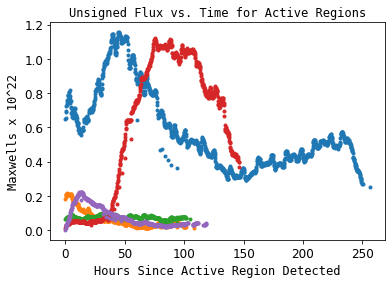

In [7]:
def plot_many_graphs(harp_ids):
    """This method will graph all the flux vs. time data from the inputted
    harp_ids on the same plot. This is useful for seeing how different flux
    emergences look simultaneously.
    """
    c = drms.Client()
    for harp_id in harp_ids:
        keys = query_data(harp_id, c)
        time_data = get_time_data(keys)
        plot_graph(keys, time_data)
    plt.show()
plot_many_graphs(harp_ids[:5])

In [8]:
def create_csv(keys, time_data, harp_id):
    """Creates a csv file in ./data/[harp_id].csv with two 
    columns: time and unsigned_flux.
    """
    data_dir = './data/'
    filename = data_dir + str(harp_id) + '.csv'
    with open(filename, 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['time', 'unsigned_flux'])
        for i in range(len(keys.USFLUX)):
            writer.writerow([time_data[i], keys.USFLUX[i]])

In [9]:
def create_all_csvs(harp_ids):
    """This method creates a csv file with time and unsigned flux for
    all the HARP IDs in the inputted harp_ids.
    """
    c = drms.Client()
    for harp_id in harp_ids:
        keys = query_data(harp_id, c)
        time_data = get_time_data(keys)
        create_csv(keys, time_data, harp_id)
#create_all_csvs(harp_ids)

In [10]:
def get_flare_data(t_start, t_end, min_event):
    """This method simply grabs data from the GOES database. It returns
    the metadata associated with each flaring active region greater in event
    size than min_event and between time t_start and t_end.
    """
    time_range = sunpy.time.TimeRange(t_start, t_end)
    results = sunpy.instr.goes.get_goes_event_list(time_range, 'C1')
    return results

In [11]:
def get_flare_data(harp_ids):
    """This method accesses the GOES database to get the flare data for each
    HARP ID in the inputted harp_ids.
    """
    c = drms.Client()
    first_keys = query_data(harp_ids[0], c)
    t_start = first_keys.T_REC[0]
    last_keys = query_data(harp_ids[-1], c)
    t_end = last_keys.T_REC[len(last_keys.T_REC) - 1]
    print('Time range:', t_start, 'to', t_end)

    return get_flare_data(t_start, t_end, 'C1')

#flare_data = get_flare_data(harp_ids)
#print(len(flare_data))

In [12]:
def write_noaa_data_to_csv(flare_data):
    with open('./data/noaa_data.csv', 'w') as csv_file:
        field_names = flare_data[0].keys()
        writer = csv.DictWriter(csv_file, fieldnames=field_names)
        writer.writeheader()
        for flare in flare_data:
            writer.writerow(flare)

#write_noaa_data_to_csv(flare_data)

In [13]:
def get_noaa_data_from_csv():
    noaa_flare_set = []
    with open('./data/noaa_data.csv', 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            noaa_flare_set.append(dict(row))
    return noaa_flare_set

flare_data = get_noaa_data_from_csv()

In [14]:
def get_flared_noaa_id_list(flare_data):
    """This method returns a list of all the NOAA IDs that have
    flared, based on the data passed in from flare_data.
    """
    noaa_flare_set = set()
    for flare in flare_data:
        noaa_flare_set.add(int(flare['noaa_active_region']))
    return noaa_flare_set

noaa_flare_set = get_flared_noaa_id_list(flare_data)
print(len(noaa_flare_set))

824


In [15]:
def has_flared(harp_id, harp_noaa_dict, noaa_flare_set):
    """Returns a boolean corresponding to whether the given active
    region corresponding to the harp_id flared or not.
    """
    for noaa_id in harp_noaa_dict[harp_id]:
        if int(noaa_id) in noaa_flare_set:
            return True
    return False

In [16]:
def count_flared_num(harp_ids):
    """This method returns the number of active regions in the inputted
    harp_ids that have flared.
    """
    number_flared = 0
    for harp_id in harp_ids:
        if has_flared(harp_id, harp_noaa_dict, noaa_flare_set): number_flared += 1
    return number_flared

number_flared = count_flared_num(harp_ids)
print(number_flared, 'active regions flared out of', len(harp_ids))

662 active regions flared out of 1335


In [17]:
def mean_flux(flux_data):
    return np.mean(flux_data)

In [18]:
def std_flux(flux_data):
    return np.std(flux_data)

In [19]:
def max_flux(flux_data):
    return max(flux_data)

In [20]:
def time_range(time_data):
    return np.ptp(time_data)

In [21]:
def max_flux(flux_data):
    return np.max(flux_data)

In [22]:
def slope_to_max(flux_data, time_data):
    max_flux_value = (max_flux(flux_data))
    i = flux_data.index(max_flux_value)
    if time_data[i] == 0: # TODO: Investigate why/when this happens
        return 0
    return max_flux_value / time_data[i]

In [23]:
def extract_features(harp_id):
    """Given a harp_id, this method returns an array of features corresponding to the
    active region corresponding to the harp_id.

    Current features are:
        Mean unsigned flux
        Standard deviation of unsigned flux
        Time range (i.e. how long the active region existed)

    NOTE: in order for this method to work, there must exist a csv file containing time and
    unsigned flux in ./data/[harp_id].csv. This can be obtained using the create_csv method.
    """
    # First get data from CSV
    filename = './data/' + str(harp_id) + '.csv'
    time_data = []
    flux_data = []
    with open(filename, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        next(reader)  # Skip header
        for row in reader:
            time_data.append(float(row[0]))
            flux_data.append(float(row[1])/1e21)

    # Extract features
    features = []
    features.append(mean_flux(flux_data))
    features.append(std_flux(flux_data))
    features.append(max_flux(flux_data))
    features.append(time_range(time_data))
    features.append(slope_to_max(flux_data, time_data))
    
    return features

In [24]:
print(extract_features(1))

[5.765639281475541, 2.257557397315269, 11.55301, 256.2, 0.2555975663716814]


In [26]:
def create_binary_learning_dataset(harp_ids):
    """Given a harp_id, this method returns two arrays: x and y. The x array is an array of
    feature arrays corresponding to each harp_id. y is an array of booleans indicating whether
    each active region flared or not.
    The output of this method can easily be applied to a machine learning algorithm.
    """
    x, y = [], []
    for harp_id in harp_ids:
        x.append(extract_features(harp_id))
        y.append(has_flared(harp_id, harp_noaa_dict, noaa_flare_set))
    return x, y

x, y = create_binary_learning_dataset(harp_ids)

In [27]:
def scale_x_data(x):
    """Method to scale each feature in the inputted x data to a range of 0 to 1.
    Returns the scaled data.
    """
    scaler = MinMaxScaler()
    return scaler.fit_transform(x)

x = scale_x_data(x)

## Different Classification Algorithms and Their Pros and Cons

1. Suppport Vector Machines (SVMs)
  * SVMs work by constructing hyper-planes in higher dimensional space. This can be used for classification by maximizing the distance between the hyper-plane and the training data of any class.
  * This is a good choice because it is a versatile classification algorithm.
2. Stochastic Gradient Descent
  * Creates a linear classifier to minimize loss.
  * Less versatile than SVMs (this should not be an issue for the binary classification, however).
  * Scikitlearn has the following built-in loss functions: hinge loss, modified Huber, and logistic.
3. Multi-layer Perceptron
  * Can learn non-linear models.
  * Doesn't necessarily find global optimum: different initial weights can alter validation accuracy.
  * Needs tweaking of hyperparameters such as the number of hidden neurons, layers, and iterations to work well.
4. AdaBoost (Boosting algorithm)
  * Principle is to combine many weak learners to create one strong model.
  * Each weak learner concentrates on the examples that are missed by the previous learners.
5. Random Forest
  * Each tree is built from a random sample of the total data (with replacement).
  * This tends to reduce the overall bias.

In [28]:
def fit_algorithm(clf, x, y, n=1):
    """This method will fit the given classifier clf to the input x, y data
    and will return the training and test accuracy of the model.
    This method will randomize the train/test split n number of times and will
    return the average train/test accuracy."""
    # TODO: Make this run the clf 100 times with random samples
    avg_train, avg_test = 0, 0
    for _ in range(n):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        clf.fit(x_train, y_train)
        avg_train += clf.score(x_train, y_train)
        avg_test += clf.score(x_test, y_test)
    return avg_train / n, avg_test / n

In [29]:
def print_info(clf, x, y, algorithm_name, best_accuracy=0, best_algorithm=None):
    """This method streamlines the code required to fit the given clf to the 
    model, as well as print out important statistics. This method returns the new
    best algorithm and best accuracy, based on the test accuracy.
    """
    print(algorithm_name + ":")
    train_accuracy, test_accuracy = fit_algorithm(clf, x, y, 50)
    print('> Train accuracy:', train_accuracy)
    print('> Test accuracy:', test_accuracy)
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_algorithm = algorithm_name
    return best_algorithm, best_accuracy

In [30]:
def run_learning_algorithms(x, y):
    """This method runs different machine learning (ML) algorithms and prints 
    statements indicated the accuracy, finally printing the best overall algorithm 
    in terms of test accuracy.
    
    Current ML algorithms:
        Support Vector Machine
        Stochastic Gradient Descent
        Multi-layer Perceptron
        AdaBoost
        Random Forest
    """
    best_accuracy = 0
    best_algorithm = None

    algorithm_name = 'Support Vector Machine'
    clf = svm.SVC(gamma='scale')
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.support_vectors_, '\n')

    algorithm_name = 'Stochastic Gradient Descent'
    clf = SGDClassifier(loss="hinge", penalty="l2")
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.coef_, '\n')

    algorithm_name = 'Multi-layer Perceptron'
    clf = MLPClassifier(max_iter=500)
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.loss_, '\n')

    algorithm_name = 'AdaBoost'
    clf = AdaBoostClassifier(n_estimators=50, random_state=0)
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.feature_importances_, '\n')

    algorithm_name = 'Random Forest'
    clf = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=0)
    best_algorithm, best_accuracy = print_info(clf, x, y, algorithm_name, best_accuracy, best_algorithm)
    print('>', clf.feature_importances_, '\n')

    print('The best algorithm is', best_algorithm, 'with a test accuracy of', best_accuracy)

run_learning_algorithms(x, y)

Support Vector Machine:
> Train accuracy: 0.7862137862137863
> Test accuracy: 0.7804790419161676
> [[0.07072132 0.08235363 0.08210915 0.59962139 0.00644384]
 [0.03149156 0.03048063 0.03825384 0.64363464 0.04601228]
 [0.01708201 0.01999898 0.02192251 0.52011358 0.00694934]
 ...
 [0.0618603  0.09090062 0.07229779 0.40511122 0.01013112]
 [0.05166297 0.02890748 0.0456214  0.45385708 0.01713002]
 [0.01811559 0.04129099 0.03415511 0.41883578 0.00382075]] 

Stochastic Gradient Descent:
> Train accuracy: 0.7744455544455545
> Test accuracy: 0.7749700598802395
> [[11.94468805  8.83074367 11.37463467  0.74773377  1.59832816]] 

Multi-layer Perceptron:
> Train accuracy: 0.7835564435564437
> Test accuracy: 0.7807185628742512
> 0.43462865012606067 

AdaBoost:
> Train accuracy: 0.8172427572427572
> Test accuracy: 0.7650299401197606
> [0.26 0.2  0.22 0.16 0.16] 

Random Forest:
> Train accuracy: 0.7900099900099901
> Test accuracy: 0.7838922155688622
> [0.34694791 0.27781064 0.34477114 0.02952874 0.000

TODO:
- ~~Try SVM~~
- ~~Look up and *write out* pros and cons of different classification algorithms~~
- Look more at the graphs and think about features
  - Make function that outputs random graphs that are either flares or not flares and see if we can find any visual differences
  - Think about regression for graphs: do these graphs look like functions?
- Think about how the data can be serialized in different ways: I feel like std of different timelengths is a bad measurement; I should normalize this
- Look up and read related research
- ~~Ping rachel and see how her progress is going (THURSDAY)~~
- Write about each code block/set of code blocks
- Read SUNPY documentation
- Make sure data is shuffled